# Cluster

Taking our clean df from 1_wrangle, checking assumptions, figuring out how many clusters to extract, and clustering on dietary patterns.


## Housekeeping

In [224]:
# If in colab, mount drive and set wd
# If local, set wd to parent of notebook
import os
import re

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ds1_nhanes/')
except:
  from pathlib import Path
  if not re.search(r'ds1_nhanes$', str(os.getcwd())):
    os.chdir(Path(os.getcwd()).parent)

print(os.getcwd())

c:\Users\cdonov12\local\repos\ds1_nhanes


## K means clustering using sklearn

### Import necessary libraries and wrangled dataset

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read in the cleaned dietary recall data matched with FPED
nhanes = pd.read_csv('data/clean/nhanes_2017_2023_clean.csv', usecols = [0] + [1] + list(range(3, 40)))

# Remove columns with 'total' in name, also meat (includes other meat vars)
# I think this covers all the obviously collinear variables?
nhanes = nhanes.loc[:, ~nhanes.columns.str.contains('total|meat', case=False)]

# Pull out just food groups
foodgroups = nhanes.iloc[:, 2:]
print(foodgroups.columns)
print(foodgroups.shape)

# break out the identifier and features
id = nhanes.iloc[:,0]


Index(['f_citmlb_(cup_eq)', 'f_other_(cup_eq)', 'f_juice_(cup_eq)',
       'v_drkgr_(cup_eq)', 'v_redor_tomato_(cup_eq)', 'v_redor_other_(cup_eq)',
       'v_starchy_potato_(cup_eq)', 'v_starchy_other_(cup_eq)',
       'v_other_(cup_eq)', 'v_legumes_(cup_eq)', 'g_whole_(oz_eq)',
       'g_refined_(oz_eq)', 'pf_organ_(oz_eq)', 'pf_poult_(oz_eq)',
       'pf_seafd_hi_(oz_eq)', 'pf_seafd_low_(oz_eq)', 'pf_eggs_(oz_eq)',
       'pf_soy_(oz_eq)', 'pf_nutsds_(oz_eq)', 'pf_legumes_(oz_eq)',
       'd_milk_(cup_eq)', 'd_yogurt_(cup_eq)', 'd_cheese_(cup_eq)',
       'oils_(grams)', 'solid_fats_(grams)', 'add_sugars_(tsp_eq)',
       'a_drinks_(no._of_drinks)'],
      dtype='object')
(19386, 27)


### Exploring Scaling and PCA

[When working with distance-based algorithms, like k-Means Clustering, we must normalize the data. If we do not normalize the data, variables with different scaling will be weighted differently in the distance formula that is being optimized during training. The different FPED categories have different units, cup vs. oz, and each food may have a different range of total weight consumed.

StandardScaler is commonly used for standardization:]

In [226]:
# import sci-kit for standardscaler
from sklearn.preprocessing import StandardScaler

# initialize the StandardScaler
scaler = StandardScaler()

# apply StandardScaler to the
foodgroups_scaled = scaler.fit_transform(foodgroups)

Running PCA and exploring it here

In [227]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(foodgroups_scaled)

# eigenvalues
eigenvalues = pca.explained_variance_
eigenvalues.sort()
print(f'Eigenvalues:\n {eigenvalues}')

# How many are above 1?
eigen_over_1 = len(eigenvalues[eigenvalues > 1])
print(f'\nWe have {eigen_over_1} eigenvalues over 1')

Eigenvalues:
 [2.42650851e-05 2.82045852e-01 4.32831681e-01 4.87274688e-01
 6.16193689e-01 6.51739678e-01 6.74234906e-01 7.51683116e-01
 7.74878549e-01 7.83373632e-01 8.21937248e-01 8.35154171e-01
 8.60719039e-01 8.80806022e-01 8.99026071e-01 9.40539608e-01
 9.47211082e-01 9.77972205e-01 1.00532335e+00 1.01222419e+00
 1.07334971e+00 1.14234603e+00 1.17051164e+00 1.56463435e+00
 1.73643089e+00 2.03345894e+00 3.64546822e+00]

We have 9 eigenvalues over 1


Let's try it again with just 5 for interpretability

In [228]:
pca = PCA(n_components=5)
pca.fit(foodgroups_scaled)

PCA(n_components=5)

First check out the eigenvalues

In [229]:
# Summary table
summary = pd.DataFrame({
    'Eigenvalue': explained_variance,
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Variance': explained_variance_ratio.cumsum()
}, index=[f'PC{i+1}' for i in range(pca.n_components_)])
print(summary)

     Eigenvalue  Explained Variance Ratio  Cumulative Variance
PC1    3.645468                  0.135010             0.135010
PC2    2.033459                  0.075309             0.210320
PC3    1.736431                  0.064309             0.274629
PC4    1.564634                  0.057946             0.332575
PC5    1.170512                  0.043350             0.375925


Our highest eigenvalue is 3.645, and just goes down from there. This means that the first component brings 3.645 variables worth of variance. That is not terribly impressive considering how many variables we have.

Now a printout of loadings. Loadings show much each variable contributes to the component. Large positive numbers mean strong positive association. 0 is no association

In [230]:
# Eigenvalues
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

# Loadings table
loadings = pd.DataFrame(
    data=pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=foodgroups.columns
)

styled_loadings = loadings.style.background_gradient(
    cmap='coolwarm', axis=None, vmin=-1, vmax=1
).format("{:.2f}")

styled_loadings

,PC1,PC2,PC3,PC4,PC5
f_citmlb_(cup_eq),0.23,0.05,-0.09,0.30,-0.03
f_other_(cup_eq),0.23,0.08,-0.02,0.39,0.06
f_juice_(cup_eq),0.10,-0.05,0.13,0.11,0.33
v_drkgr_(cup_eq),0.19,0.12,-0.30,-0.01,-0.01
v_redor_tomato_(cup_eq),0.22,-0.05,-0.10,-0.32,-0.13
v_redor_other_(cup_eq),0.19,0.08,-0.23,0.09,0.01
v_starchy_potato_(cup_eq),0.07,-0.22,0.07,-0.26,0.01
v_starchy_other_(cup_eq),0.08,0.05,-0.02,0.08,0.37
v_other_(cup_eq),0.28,0.08,-0.32,-0.21,-0.08
v_legumes_(cup_eq),0.17,0.58,0.29,-0.19,0.02


PC1 is heavily influenced by oils, fats, sugars, but also v_other? That's rather odd. PC2 has huge loadings from legumes. It looks like both legumes variables are identical - they might be collinear because they are counting a certain proportion of the same consumption in both categories. PC3 is refined grains, milk, sugars? PC4 is fruit and whole grains, with some dairy. PC5 seafood and starches. None of this really makes much sense to me. 

Let's check the correlation beteen v legumes and pf legumes:

In [231]:
# print(foodgroups.loc[:, foodgroups.columns.str.contains('legumes')])
pf = foodgroups['pf_legumes_(oz_eq)']
v = foodgroups['v_legumes_(cup_eq)']
np.corrcoef(pf, v)

array([[1.        , 0.99997545],
       [0.99997545, 1.        ]])

Holy moly, we have perfect collinearity with v legumes and pf legumes. Makes sense because it's from the same food. We have to remove one of these, or maybe put them together?

### Real Preprocessing

For now just removing v_legumes to see if it fixes anything. Also removing totals and meat

In [213]:
# Reduce to food groups, but WITHOUT v_legumes, or totals, or meat
foodgroups = nhanes.loc[:, ~nhanes.columns.str.contains('total|meat|v_legumes|SEQN|weight', case=False)]
print(foodgroups.shape)
print(foodgroups.columns)

(19386, 26)
Index(['f_citmlb_(cup_eq)', 'f_other_(cup_eq)', 'f_juice_(cup_eq)',
       'v_drkgr_(cup_eq)', 'v_redor_tomato_(cup_eq)', 'v_redor_other_(cup_eq)',
       'v_starchy_potato_(cup_eq)', 'v_starchy_other_(cup_eq)',
       'v_other_(cup_eq)', 'g_whole_(oz_eq)', 'g_refined_(oz_eq)',
       'pf_organ_(oz_eq)', 'pf_poult_(oz_eq)', 'pf_seafd_hi_(oz_eq)',
       'pf_seafd_low_(oz_eq)', 'pf_eggs_(oz_eq)', 'pf_soy_(oz_eq)',
       'pf_nutsds_(oz_eq)', 'pf_legumes_(oz_eq)', 'd_milk_(cup_eq)',
       'd_yogurt_(cup_eq)', 'd_cheese_(cup_eq)', 'oils_(grams)',
       'solid_fats_(grams)', 'add_sugars_(tsp_eq)',
       'a_drinks_(no._of_drinks)'],
      dtype='object')


In [214]:
# import sci-kit for standardscaler
from sklearn.preprocessing import StandardScaler

# initialize the StandardScaler
scaler = StandardScaler()

# apply StandardScaler to the
foodgroups_scaled = scaler.fit_transform(foodgroups)

In [215]:
from sklearn.decomposition import PCA
pca = PCA()
foodgroups_pca = pca.fit_transform(foodgroups_scaled)

### Apply k means clustering

In [216]:
# import sci-kit for k means clustering
from sklearn.cluster import KMeans

# apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(foodgroups_pca, sample_weight=nhanes['weight_2d'])

# display the first few rows
print(nhanes_clustered.head())

     SEQN  Cluster
0  109263        1
1  109264        1
2  109265        1
3  109266        1
4  109269        1


Check out a plot with this test run:

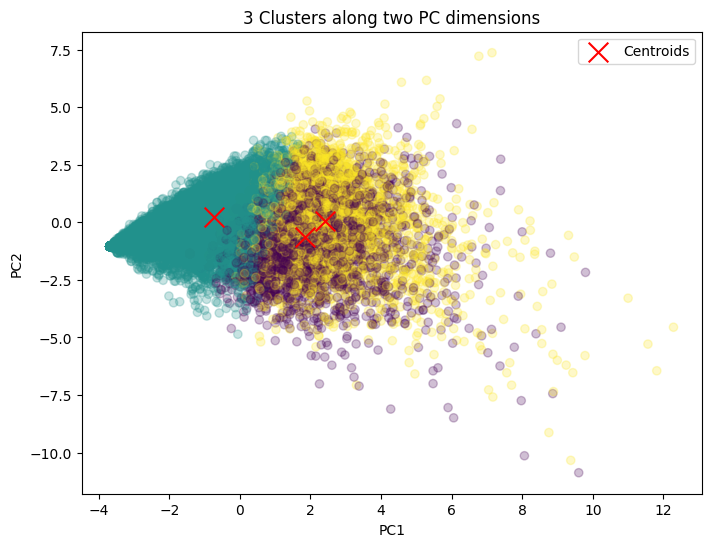

In [217]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    foodgroups_pca[:, 0],
    foodgroups_pca[:, 1],
    c=clusters,
    cmap='viridis',
    alpha=0.25
)
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    marker='x',
    s=200,
    label='Centroids'
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("3 Clusters along two PC dimensions")
plt.legend()

# Save it
plt.savefig('outputs/checkin_2/k3_cluster.png')

plt.show()


Sorry to say that this looks pretty far from spherical

### Determine optimal number of clusters

[We do not know how many clusters we should be using, the Silhoette Score and Elbow Method is commonly used to find the optimal number of clusters to ensure we are not overfitting with too many clusters or underfitting with too few.

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

The elbow method measures how tightly points cluster around centroids using sum of squared distances (SSD), the elbow is where the SSD stops decreasing sharply.]

In [218]:
from sklearn.metrics import silhouette_score
from matplotlib.ticker import FuncFormatter

K = range(2, 7)
fits = []
elbow_score = []
silhouette_scores = []

for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(foodgroups_pca, sample_weight=nhanes['weight_2d'])

    # append the model to fits
    fits.append(model)

    # Append the silhouette score to scores
    silhouette_scores.append(silhouette_score(foodgroups_pca, model.labels_, metric='euclidean'))

    # Store inertia (sum of squared distances)
    elbow_score.append(model.inertia_)

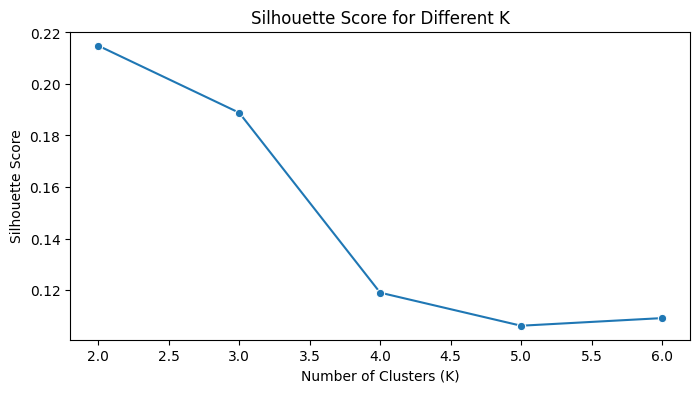

In [199]:
# plot Silhouette Score
plt.figure(figsize=(8, 4))
sns.lineplot(x=K, y=silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K")
# plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.show()

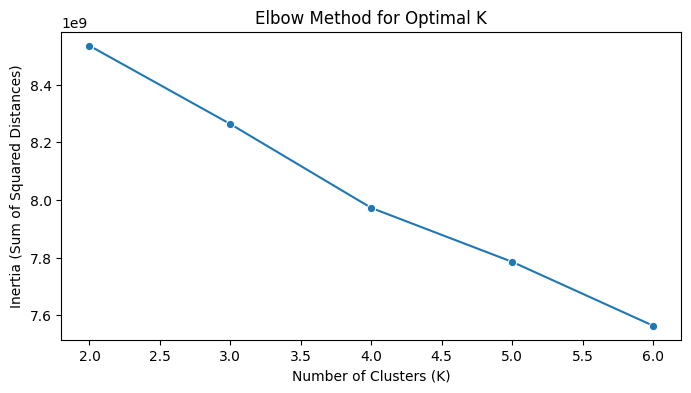

In [200]:
# plot Elbow Method
plt.figure(figsize=(8, 4))
sns.lineplot(x=K, y=elbow_score, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K")
# plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.show()

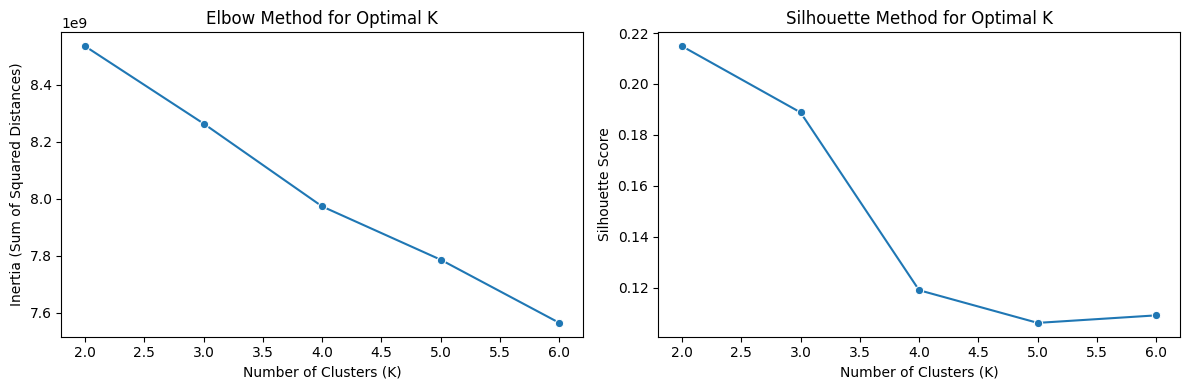

In [201]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Left plot: Elbow Method
sns.lineplot(x=K, y=elbow_score, marker="o", ax=axs[0])
axs[0].set_xlabel("Number of Clusters (K)")
axs[0].set_ylabel("Inertia (Sum of Squared Distances)")
axs[0].set_title("Elbow Method for Optimal K")

# Right plot: Silhouette Method (just an example — replace with correct data!)
sns.lineplot(x=K, y=silhouette_scores, marker="o", ax = axs[1])
axs[1].set_xlabel("Number of Clusters (K)")
axs[1].set_ylabel("Silhouette Score")
axs[1].set_title("Silhouette Method for Optimal K")

plt.tight_layout()
plt.savefig('outputs/checkin_2/elbow_silhouette.png', dpi=300)
plt.show()



Check out plots for a series of these:

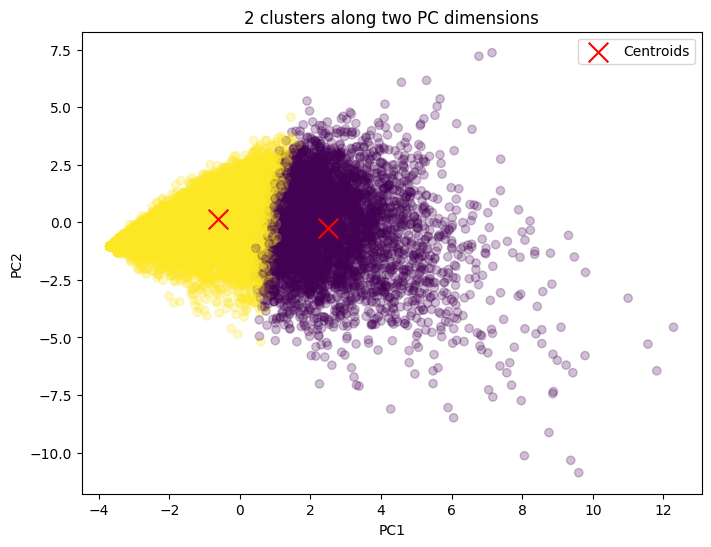

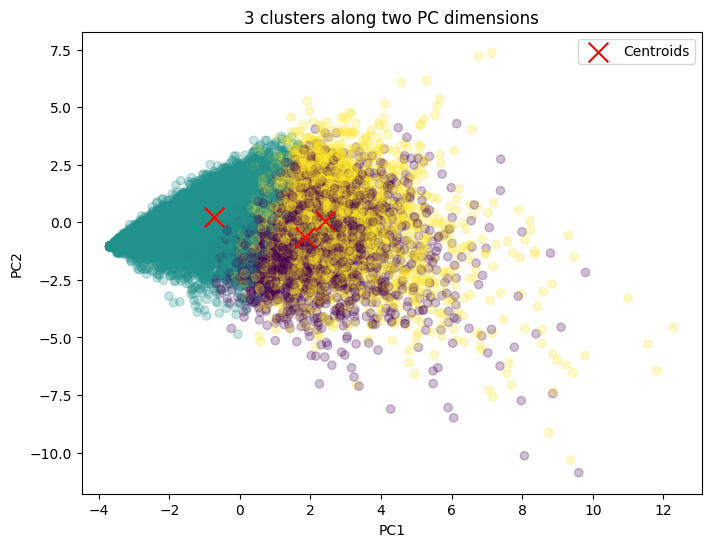

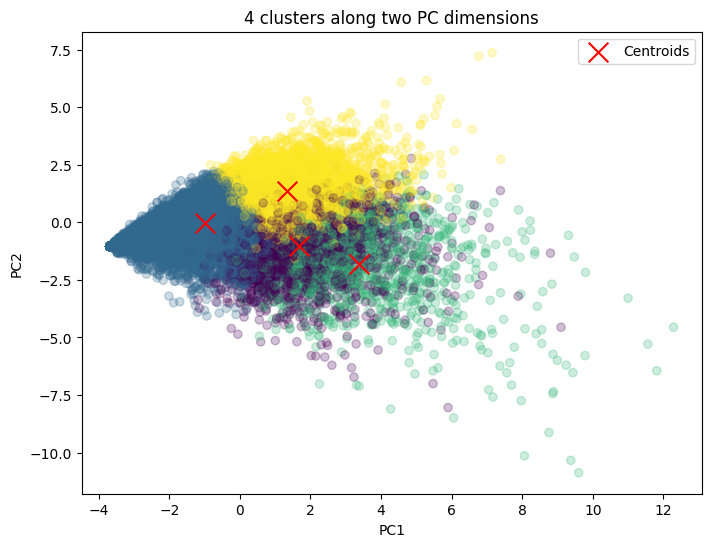

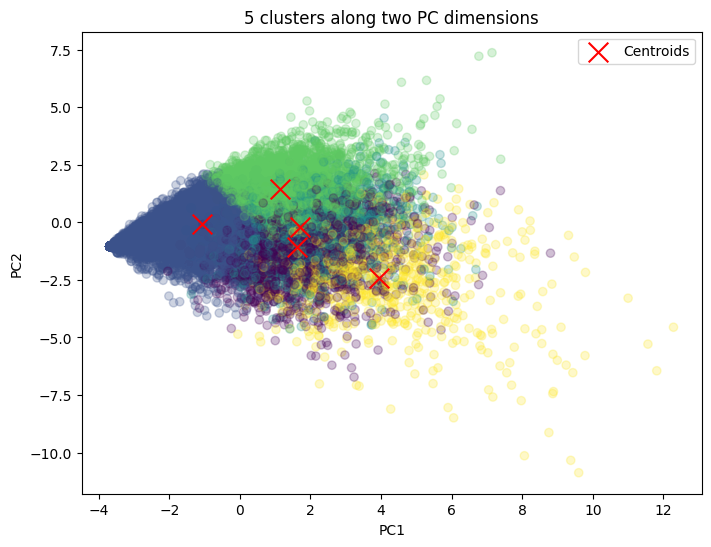

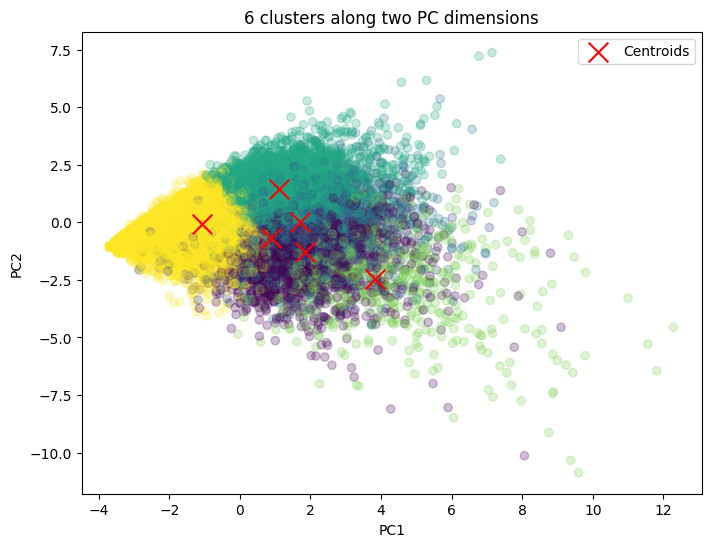

In [219]:
for fit in fits:
    clusters = fit.fit_predict(foodgroups_pca, sample_weight=nhanes['weight_2d'])

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        foodgroups_pca[:, 0],
        foodgroups_pca[:, 1],
        c=clusters,
        cmap='viridis',
        alpha=0.25
    )
    centers = fit.cluster_centers_
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        c='red',
        marker='x',
        s=200,
        label='Centroids'
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{fit.n_clusters} clusters along two PC dimensions")
    plt.legend()
    plt.show()

### Split Half Reliability

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import adjusted_rand_score

def split_half_val(df, k=3, random_state=None):
    # Split data in half
    train, test = train_test_split(df, test_size=0.5, random_state=random_state)

    # Cluster training half
    km_train = KMeans(n_clusters=k, random_state=random_state).fit(train)
    train_labels = km_train.labels_

    # NN to pair each training point with a test point
    nn = NearestNeighbors(n_neighbors=1).fit(train)
    distances, indices = nn.kneighbors(test)
    nn_labels = train_labels[indices.flatten()]

    # Cluster test set
    km_test = KMeans(n_clusters=k, random_state=random_state).fit(test)
    test_labels = km_test.labels_

    # Get Adjusted Rand Scores that compare test labels to nn labels
    ari = adjusted_rand_score(test_labels, nn_labels)
    return ari

# Second function just makes iterations easier
def iterate_val(df, k=3, n_iter=10, random_state=42):
    aris = []
    for i in range(n_iter):
        ari = split_half_val(df, k=k, random_state=random_state + i)
        aris.append(ari)
    return aris

In [16]:
aris = iterate_val(foodgroups_pca, k=3, n_iter=10, random_state=42)
print(aris)
print(f"Mean ARI: {round(np.mean(aris), 3)}")

[0.5322835215585512, 0.5483038651161811, 0.5267115728585237, 0.518611556714917, 0.5232911037908461, 0.5502123844452814, 0.5170537127965963, 0.5638334269206776, 0.5815622785268127, 0.5591933792495959]
Mean ARI: 0.542


## Gaussian Mixture

Trying Gaussian mixture with 2 through 6 components

In [220]:
from sklearn.mixture import GaussianMixture

gm_fits = []
gm_labels = []

for i in np.arange(2, 7):
    fit = GaussianMixture(n_components=i, random_state=42).fit(foodgroups_pca)
    label = fit.predict(foodgroups_pca)
    gm_fits.append(fit)
    gm_labels.append(label)

Plot them

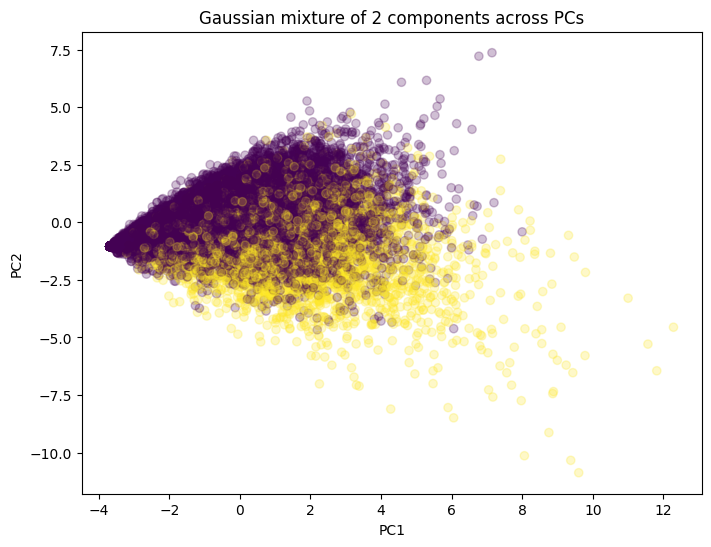

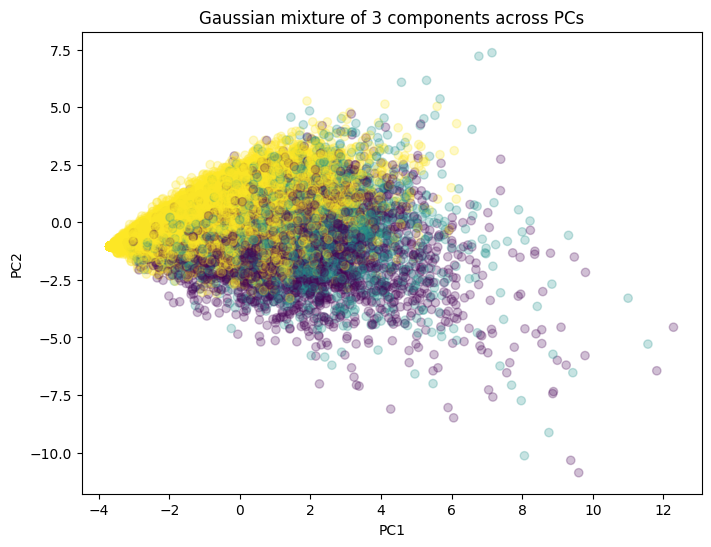

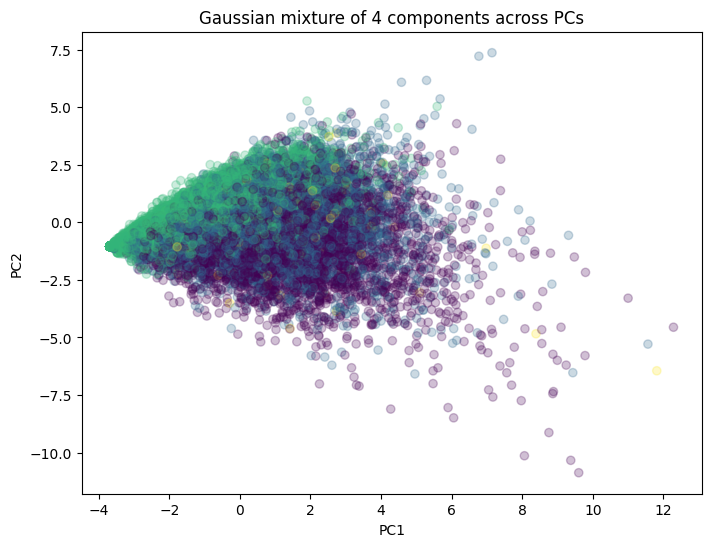

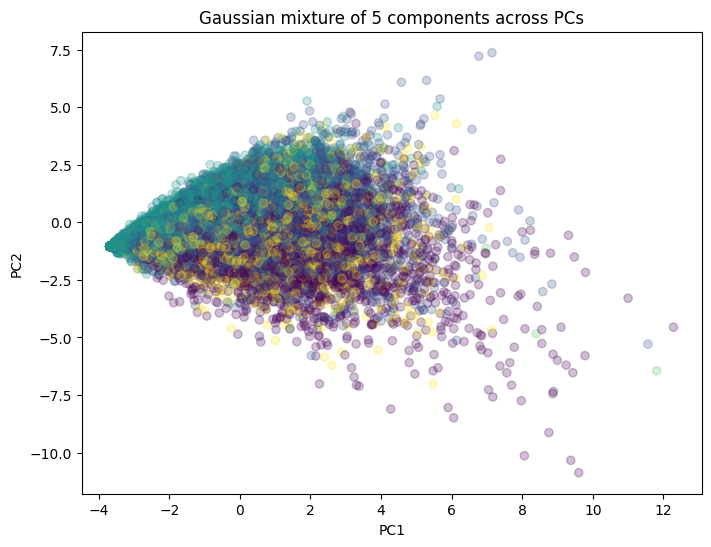

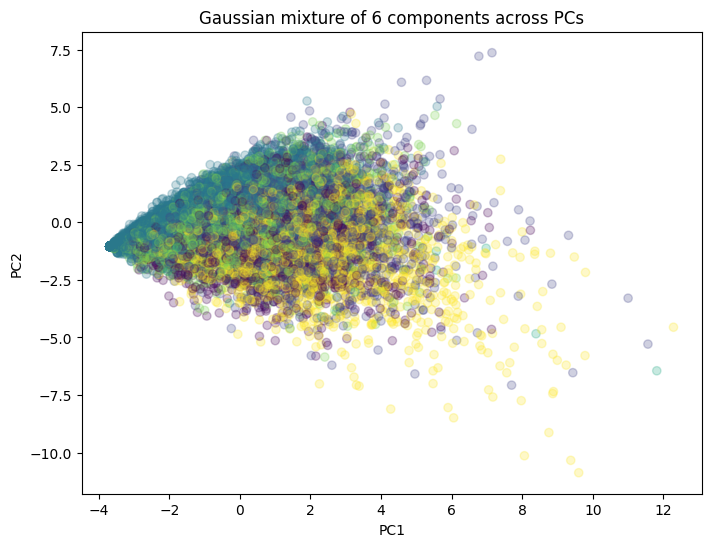

In [221]:
for i in np.arange(2, 7):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        foodgroups_pca[:, 0],
        foodgroups_pca[:, 1],
        c=gm_labels[i - 2],
        cmap='viridis',
        alpha=0.25
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Gaussian mixture of {i} components across PCs")
    plt.show()

Check AIC and BIC curves. Lower numbers are better in each case, only interpreted relative to other values.

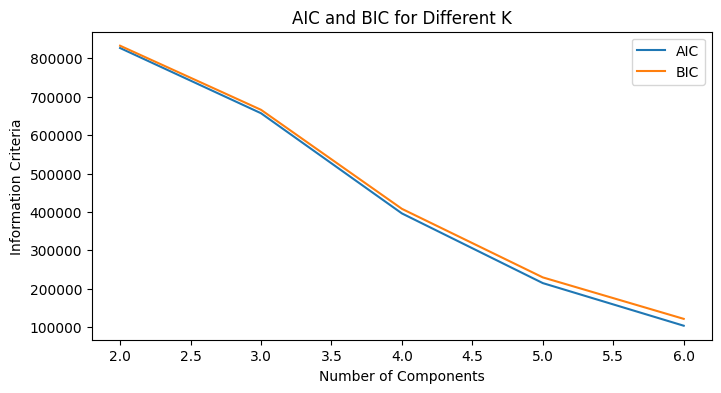

In [222]:
AIC = [fit.aic(foodgroups_pca) for fit in gm_fits]
BIC = [fit.bic(foodgroups_pca) for fit in gm_fits]

plt.figure(figsize=(8, 4))
plt.plot(np.arange(2, 7), AIC, label='AIC')
plt.plot(np.arange(2, 7), BIC, label='BIC')
plt.xlabel("Number of Components")
plt.ylabel("Information Criteria")
plt.title("AIC and BIC for Different K")
plt.legend()
plt.show()

This is not helping much at all. Perhaps a small kink at 4.

## t-SNE

Try visualizing same plots with t-distributed Stoachastic Neighbor Embedding.

What does it do? "t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results."

In other words, I have no idea. But it is just a way to visualize clusters, not a clustering method in itself.

Note - this takes about 8 minutes to run, so I am commenting it out so we don't run it accidentally.

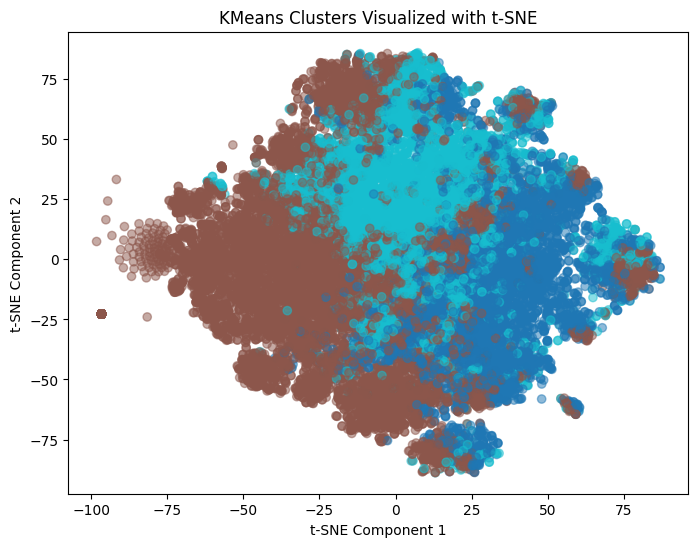

In [ ]:
# from sklearn.manifold import TSNE

# KMeans
# kmeans = KMeans(n_clusters=3, random_state=42)
# labels = kmeans.fit_predict(foodgroups_pca)

# # fit TSNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
# foodgroups_tsne = tsne.fit_transform(foodgroups_pca)

# plt.figure(figsize=(8, 6))
# plt.scatter(
#     foodgroups_tsne[:, 0],
#     foodgroups_tsne[:, 1],
#     c=labels,
#     cmap='tab10',
#     alpha=0.5
# )
# plt.title("KMeans Clusters Visualized with t-SNE")
# plt.xlabel("t-SNE Component 1")
# plt.ylabel("t-SNE Component 2")
# plt.show()

As you can see, it is very goopy